In [1]:
!pip install pyLDAvis -qq
!pip install -qq -U gensim
!pip install spacy -qq
!pip install matplotlib -qq
!pip install seaborn -qq
!python -m spacy download en_core_web_md -qq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import re

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


### Parser functions

In [2]:
def compute_initials(string):
    # Hyphen is used to format id so any original hyphen will be replaced.
    hyphen_regex = re.compile("-")
    string_filtered = hyphen_regex.sub("", string)

    word_list= string_filtered.split()
    initials = ""
    for i in range(len(word_list)):
        initials += word_list[i][0]
    return initials

def date_parser(string):
    pattern = re.compile(r'(\D{3})\s(\d{1,2}),\s(\d{4})')
    matches = pattern.search(string)
    
    year = matches.group(3) 
    
    day = matches.group(2) 
    day = "0" + day if len(day) == 1 else day
    
    month = matches.group(1)
    if month == "Jan":
        month = "01"
    elif month == "Feb":
        month = "02"
    elif month == "Mar":
        month = "03"
    elif month == "Apr":
        month = "04"
    elif month == "May":
        month = "05"
    elif month == "Jun":
        month = "06"
    elif month == "Jul":
        month = "07"
    elif month == "Aug":
        month = "08"
    elif month == "Sep":
        month = "09"
    elif month == "Oct":
        month = "10"
    elif month == "Nov":
        month = "11"
    elif month == "Dec":
        month = "12"
    else:
        # print("Invalid month format")
        return None
    
    return year + month + day

def main_parser_proquest(dir, file_num, date):
    pattern = re.compile(r'Full\stext:\s(.*?)(?=____________________________________________________________)', re.DOTALL)
    pattern_sub_list = [
        re.compile(r'\nSubject:.*\n'), 
        re.compile(r'\nBusiness indexing term:.*\n'),
        re.compile(r'\nLocation:.*\n'),
        re.compile(r'\nPeople:.*\n'),
        re.compile(r'\nCompany / organization:.*\n'),
        re.compile(r'\nIdentifier /\s?keyword:.*\n'),
        re.compile(r'\nURL:.*\n'),
        ]
    
    raw_article_list = []
    for text_number in range(1, file_num+1):
        proquest_text_title = f"ProQuestDocuments-{date}-{text_number}.txt"
        with open(f"{dir}/{proquest_text_title}", 'r') as f:
            text = f.read()
            for s in pattern_sub_list:
                text = s.sub("", text)
            matches = pattern.finditer(text)
            
            for match in matches:
                raw_article_list.append(match.group(1))
    
    return raw_article_list

def text2dict(raw_article_list):
    pattern_text = re.compile(r'(.+?)Title:\s', re.DOTALL)
    pattern_title = re.compile(r'\nTitle:\s(.+)\n')
    pattern_date = re.compile(r'\nPublication\sdate:\s(.+)\n')
    pattern_publisher = re.compile(r'\nPublisher:\s(.+)\n')
    pattern_pub_title = re.compile(r'\nPublication\stitle:\s(.+)\n')
    pattern_source = re.compile(r'\nSource\stype:\s(.+)\n')
    pattern_doc = re.compile(r'\nDocument\stype:\s(.+)\n')

    master_dict = {}
    # id_set = set()
    # pub_title_set = set()

    for i in range(len(raw_article_list)):
        raw_text = raw_article_list[i]

        # Add text into the dictionary
        match = pattern_text.search(raw_text)
        text = match.group(1) 

        # Title
        match = pattern_title.search(raw_text)
        title = match.group(1)

        # Date 
        match = pattern_date.search(raw_text)
        try:
            date = date_parser(match.group(1)) if match else None
        except AttributeError:
            # print(match.group(1))
            # AttributeError indicates that abnormal format leading to unexpected parsing.
            date = None

        # Publisher 
        match = pattern_publisher.search(raw_text)
        publisher = match.group(1) if match else None
        
        # Publication title 
        match = pattern_pub_title.search(raw_text)
        pub_title = match.group(1) if match else None
        # pub_title_set.add(pub_title)

        # Source type 
        match = pattern_source.search(raw_text)
        source = match.group(1) if match else None
        
        # Doc type 
        match = pattern_doc.search(raw_text)
        doc = match.group(1) if match else None

        # Need to derive ID to avoid duplication.
        title_initials = compute_initials(title)
        date_element = date if date else "_"
        pub_title_element = compute_initials(pub_title) if pub_title else "_"
        # id = title_initials + "-" + date_element + "-" + pub_title_element
        id = title_initials + "-" + date_element
        
        if id not in master_dict:
            master_dict[id] = dict()
            master_dict[id]['text'] = text
            master_dict[id]['title'] = title
            master_dict[id]['date'] = date
            master_dict[id]['publisher'] = publisher
            master_dict[id]['pub_title'] = pub_title
            master_dict[id]['source'] = source
            master_dict[id]['doc'] = doc
        
    return master_dict
            

### Helper functions

In [3]:
def pub2state(pub, media_data):
    for i in range(len(media_data)):
        if media_data[i][0] == pub:
            return media_data[i][2]
    # print("Unexpected behavior.")
    return None

def pub2stance(pub, media_data):
    for i in range(len(media_data)):
        if media_data[i][0] == pub:
            return media_data[i][1]
    # print("Unexpected behavior.")
    return None

### Target media (handcraft previously)

In [4]:
target_media = (
    # ABC assume national reach. 230 articles.
    ('ABC Premium News; Sydney', 'neutral', 'national'),
    ('7.30; Sydney', 'neutral', 'national'),

    # ACT. 951 articles. But Australian prolly national reach.
    # ('The Australian (Online); Canberra, A.C.T.', 'right', 'national'),
    ('The Canberra Times; Canberra, A.C.T.', 'left', 'ACT'),
    
    # NSW
    ('News.com.au; Sydney, N.S.W.', 'right', 'national'),
    ('Sydney Morning Herald; Sydney, N.S.W.', 'left', 'NSW'),
    ('Sun-Herald; Sydney, N.S.W.', 'left', 'NSW'),
    ('The Daily Telegraph (Online); Surrey Hills, N.S.W.', 'right', 'NSW'),

    # VIC
    ('The Age; Melbourne, Vic.', 'left', 'VIC'),
    ('Herald Sun; Melbourne, Vic.', 'left', 'VIC'),
    ('Sunday Age; Melbourne, Vic.', 'left', 'VIC'),

    # SA
    ('The Advertiser; Adelaide, S. Aust.', 'right', 'SA'),
    
    # QLD
    ('The Courier - Mail; Brisbane, Qld.', 'right', 'QLD'),
    ('The Cairns Post; Cairns, Qld.', 'right', 'QLD'),
    
    # NT
    ('The Northern Territory News; Darwin, N.T.', 'unclear', 'NT'),

    # TAS
    ('Advocate; Burnie, Tas.', 'unclear', 'TAS'),
    ('The Examiner; Launceston, Tas.', 'unclear', 'TAS'),
    ('The Mercury (Online); Hobart Town', 'unclear', 'TAS'),
)

# Quick check handcrafted attribute.
# set(c for a,b,c in target_media)

### 1. Preprocess raw text

In [5]:
dir = "./data/raw_240227/voice"
file_num = 11
date = "2024-02-28"
voice_raw_list = main_parser_proquest(dir, file_num, date)
voice_dict = text2dict(voice_raw_list)

In [6]:
voice_keys = list(voice_dict.keys())
voice_text = [voice_dict[key]['text'] for key in voice_keys]
voice_pub_title = [voice_dict[key]['pub_title'] for key in voice_keys]
df = pd.DataFrame({'id': voice_keys, 'text': voice_text, 'pub_title': voice_pub_title})
df

,id,text,pub_title
0,IvtpreaLh-20231119,The spiritual home of Holden and Cold Chisel m...,"The Australian (Online); Canberra, A.C.T."
1,WtIVtPrfSftIVtPwisswdtrf-20231031,"ANTONY GREEN, ELECTION ANALYST: The ballot pap...",7.30; Sydney
2,SGlIvtprd‘fietsN-20231030,In an emotive speech delivered in Canberra on ...,"The Australian (Online); Canberra, A.C.T."
3,QclvtpfrAc-20231023,"On Queensland’s Mornington Island, where 77 pe...","The Australian (Online); Canberra, A.C.T."
4,VsNtaIvtpbAAsil-20231018,"For the Yes campaign, convinced of its righteo...","The Australian (Online); Canberra, A.C.T."
...,...,...,...
4142,Vl'opg-20230109,Professor Megan Davis insists Australians won'...,AAP Bulletin Wire; Sydney
4143,Vl'opg-20230108,Professor Megan Davis insists Australians won’...,AAP General News Wire; Sydney
4144,CbNvo-20230104,Two Nationals MPs are taking over new roles in...,AAP Bulletin Wire; Sydney
4145,Iv'wo-20230103,Academic and lawyer Megan Davis wants communit...,AAP General News Wire; Sydney


In [7]:
# Label stance and remove the ones without stance
df['edit_stance'] = df['pub_title'].apply(pub2stance, args=(target_media, ))
df = df[df['edit_stance'].astype(bool)]

In [8]:
# Our spaCy model:
nlp = en_core_web_md.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df['text']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)
df['tokens'] = tokens

/var/folders/4y/tpc_50fx70d6w16f55qld9fw0000gn/T/ipykernel_28436/3276573296.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = tokens


In [11]:
df_left = df[df['edit_stance']=='left']
df_right = df[df['edit_stance']=='right']
print(len(df_left), len(df_right))

485 460


In [12]:
# Obtain token id using Gensim Dictionary
dictionary_left = Dictionary(df_left['tokens'])
dictionary_right = Dictionary(df_right['tokens'])
# print(dictionary.token2id)

# Build corpus with some frequency conditions
dictionary_left.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
corpus_left = [dictionary_left.doc2bow(doc) for doc in df_left['tokens']]

dictionary_right.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
corpus_right = [dictionary_right.doc2bow(doc) for doc in df_right['tokens']]

### 2. Build LDA model

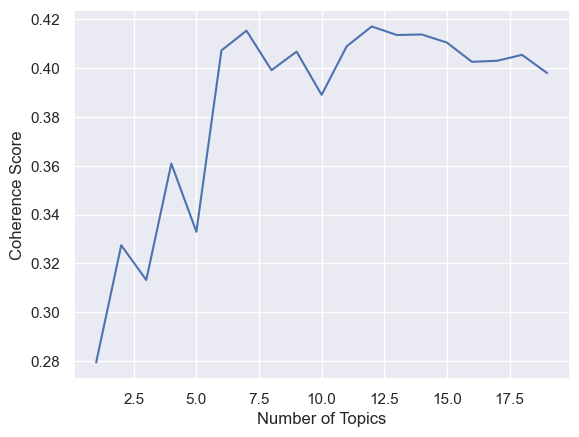

In [13]:
# For LEFT, find the number of topic with coherence, with lower `passes` and `iteration`
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus_left, id2word=dictionary_left, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus_left, dictionary=dictionary_left, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

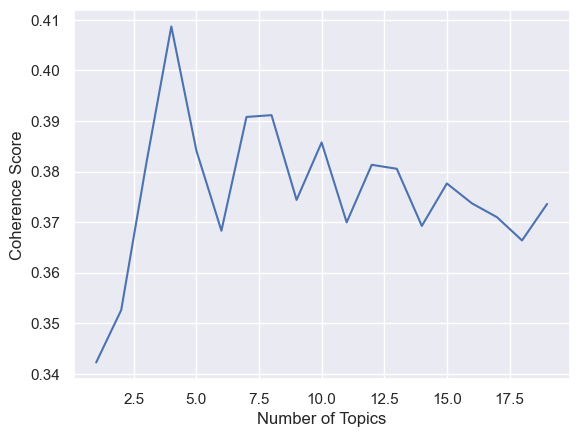

In [14]:
# For RIGHT, find the number of topic with coherence, with lower `passes` and `iteration`
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus_right, id2word=dictionary_right, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus_right, dictionary=dictionary_right, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [15]:
lda_model_left = LdaMulticore(corpus=corpus_left, id2word=dictionary_left, iterations=100, num_topics=7, workers = 4, passes=100)

In [20]:
lda_model_left.print_topics(-1)

[(0,
  '0.012*"community" + 0.009*"think" + 0.008*"country" + 0.008*"know" + 0.008*"go" + 0.008*"want" + 0.007*"nation" + 0.007*"good" + 0.007*"thing" + 0.006*"right"'),
 (1,
  '0.073*"cent" + 0.039*"voter" + 0.023*"state" + 0.018*"labor" + 0.017*"poll" + 0.017*"majority" + 0.015*"survey" + 0.011*"month" + 0.011*"resolve" + 0.011*"show"'),
 (2,
  '0.019*"debate" + 0.017*"week" + 0.015*"price" + 0.013*"group" + 0.010*"right" + 0.009*"mundine" + 0.009*"medium" + 0.008*"public" + 0.008*"ad" + 0.008*"comment"'),
 (3,
  '0.017*"sport" + 0.016*"body" + 0.014*"act" + 0.013*"rugby" + 0.013*"canberra" + 0.013*"afl" + 0.012*"ms" + 0.011*"community" + 0.011*"position" + 0.011*"club"'),
 (4,
  '0.021*"treaty" + 0.020*"thorpe" + 0.019*"nations" + 0.016*"sovereignty" + 0.015*"day" + 0.013*"country" + 0.013*"uluru" + 0.011*"senator" + 0.011*"greens" + 0.010*"community"'),
 (5,
  '0.016*"torres" + 0.016*"strait" + 0.015*"detail" + 0.015*"law" + 0.014*"propose" + 0.014*"islander" + 0.012*"body" + 0.010

In [18]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model_left, corpus_left, dictionary_left)
pyLDAvis.display(lda_display)

In [17]:
lda_model_right = LdaMulticore(corpus=corpus_right, id2word=dictionary_right, iterations=100, num_topics=4, workers = 4, passes=100)

In [19]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model_right, corpus_right, dictionary_right)
pyLDAvis.display(lda_display)

In [21]:
lda_model_right.print_topics(-1)

[(0,
  '0.018*"aboriginal" + 0.013*"yes" + 0.013*"statement" + 0.012*"campaign" + 0.012*"uluru" + 0.011*"treaty" + 0.010*"support" + 0.010*"government" + 0.009*"australian" + 0.009*"referendum"'),
 (1,
  '0.017*"government" + 0.013*"nsw" + 0.010*"mr" + 0.009*"minister" + 0.009*"community" + 0.008*"need" + 0.008*"treaty" + 0.008*"time" + 0.008*"go" + 0.008*"year"'),
 (2,
  '0.023*"nations" + 0.023*"state" + 0.020*"available" + 0.020*"aboriginal" + 0.018*"community" + 0.013*"government" + 0.012*"south" + 0.012*"sa" + 0.011*"year" + 0.008*"australian"'),
 (3,
  '0.024*"referendum" + 0.021*"vote" + 0.019*"australians" + 0.018*"yes" + 0.015*"campaign" + 0.012*"mr" + 0.012*"government" + 0.011*"support" + 0.009*"albanese" + 0.009*"cent"')]